In [1]:
import ehrapy as ep
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

adata = ep.io.read_h5ad("../../anndata_objects/adata_02_2023_pneumonia_unspecified_rest.h5ad")

Installed version 0.2.0 of ehrapy is outdated. Newest version is 0.5.0!

# Part A

In [2]:
import ehrapy as ep
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
ep.settings.n_jobs=-1

df_a = pd.read_csv("../../data_pp_notebooks/temp_pp_data_files/data_02_2023_NEW.csv")
# should remove this earlier
df_a.drop(["language", "religion", "marital_status"], inplace=True, axis=1)
# shift negative values for log_norm -> see #402 in ehrapy, do this after anndata creation!
for neg_col in ["Base Excess_min", "Base Excess_max", "Base Excess_avg", "Excrement_avg", "Excrement_min", "Excrement_max"]:
    abs_min = abs(df_a[neg_col].min())
    df_a[neg_col] = df_a[neg_col] + abs_min

obs_only = list(df_a.columns[215:415])
obs_only.extend(["disease_type_1","disease_type_2","disease_name_1", 
                 "disease_name_2","INTIME", "OUTTIME", 
                 "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", 
                 "FIRST_CAREUNIT", "LAST_CAREUNIT", "age_in_month"])

adata = ep.ad.df_to_anndata(df_a, columns_obs_only=obs_only)


Finished one_hot_encoding of autodetected columns. ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


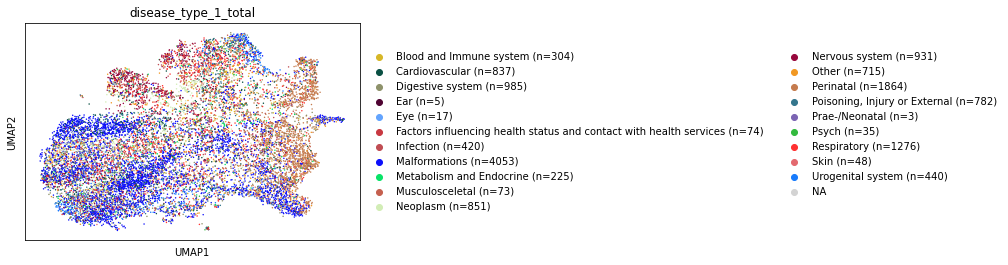

In [3]:
value_counts = adata.obs['disease_type_1'].value_counts()
custom_labels = {category: f"{category} (n={count})" for category, count in value_counts.items()}
adata.obs['disease_type_1_total'] = adata.obs['disease_type_1'].map(custom_labels)
custom_palette = {'Malformations (n=4053)': '#0C0FFB',
 'Perinatal (n=1864)': '#C57B4E',
 'Respiratory (n=1276)': '#FF3131',
 'Digestive system (n=985)': '#8E926B',
 'Nervous system (n=931)': '#97073D',
 'Neoplasm (n=851)': '#D2EDB6',
 'Cardiovascular (n=837)': '#0A5043',
 'Poisoning, Injury or External (n=782)': '#34768D',
 'Other (n=715)': '#F19823',
 'Urogenital system (n=440)': '#187BFC',
 'Infection (n=420)': '#C04D53',
 'Blood and Immune system (n=304)': '#D7B727',
 'Metabolism and Endocrine (n=225)': '#08E368',
 'Factors influencing health status and contact with health services (n=74)': '#C83841',
 'Musculosceletal (n=73)': '#C5604F',
 'Skin (n=48)': '#E3696F',
 'Psych (n=35)': '#33BA3E',
 'Eye (n=17)': '#63A4FE',
 'Ear (n=5)': '#4F0332',
 'Prae-/Neonatal (n=3)': '#7B64B3'}
ep.pp.knn_impute(adata, n_neighbours=20)
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
ep.pp.log_norm(adata_enc)
ep.pp.neighbors(adata_enc)
ep.tl.umap(adata_enc)
ep.pl.umap(adata_enc, color="disease_type_1_total", palette=custom_palette, save="fig2_disease_type")

In [4]:
diagnoses = pd.read_csv("../../V1.1.0/DIAGNOSES_ICD.csv")
# ICD codes starting with J indicate respiratory diseases
respiratory_diagnoses = diagnoses[diagnoses['ICD10_CODE_CN'].str.startswith('J')]
respiratory_icd_codes = {"J00–J06": "Acute upper respiratory infections",
"J10–J19": "Influenza and pneumonia",
"J20–J23": "Other acute lower respiratory infections",
"J30–J39": "Other diseases of upper respiratory infections",
"J40–J48": "Chronic lower respiratory diseases",
"J60–J71": "Lung diseases due to external agents",
"J80–J84": "Other respiratory diseases principally affecting the interstitium",
"J85–J87": "Suppurative and necrotic conditions of the lower respiratory tract",
"J90–J94.9": "Other diseases of the pleura",
"J95.0–J95.99": "Intraoperative and postprocedural complications of respiratory system",
"J96–J99": "Other diseases of the respiratory system"}

def get_respiratory_category(value):
    for code_range, category in respiratory_icd_codes.items():
        start, end = code_range.split('–')
        if start <= value <= end:
            return category
    return None

respiratory_diagnoses['Respiratory Category'] = respiratory_diagnoses['ICD10_CODE_CN'].apply(get_respiratory_category)


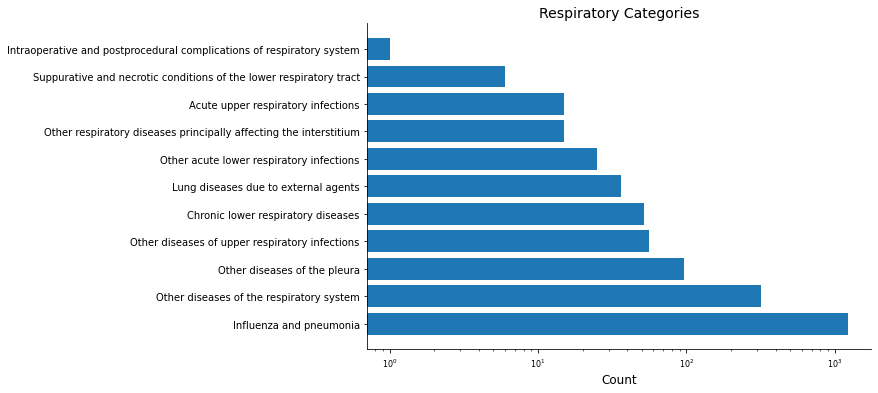

In [6]:
# Import the required libraries
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = respiratory_diagnoses['Respiratory Category'].value_counts()

# Create a horizontal stacked bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your requirement
plt.barh(category_counts.index, category_counts.values)
plt.xlabel('Count', fontsize=12)  # Update the xlabel, as the plot is rotated
plt.title('Respiratory Categories', fontsize=14)
plt.xticks(fontsize=8)  # Remove the x-axis ticks since we're rotating the plot
plt.yticks(rotation=0, ha='right', fontsize=10)  # Rotate the y-axis tick labels to 0 degrees

plt.xscale('log')  # Set the scale for x-axis to logarithmic

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set the font style for tick labels
plt.rcParams['font.family'] = 'Arial'

# Adjust the plot layout
plt.subplots_adjust(left=0.2)  # Increase the left margin to provide more space on the right side

plt.savefig('respiratory_categories.pdf', dpi=300)

# Display the plot
plt.show()

# Part B

In [11]:
df_b = df_a
df_b = df_b.loc[df_a.disease_type_1 == "Respiratory"]
# focus on J10–J19": "Influenza and pneumonia"
respiratory_diagnoses = respiratory_diagnoses.loc[respiratory_diagnoses["Respiratory Category"] == "Influenza and pneumonia"]
pneumonia_influenza_df = df_b[df_b['HADM_ID'].isin(respiratory_diagnoses['HADM_ID'])]

# remove some patients with diseases falsely assigned into the pneumonia and influenza category (most likely due to an annotation failure during the dataset generation)
exclude_diagnoses = ["Pneumothorax, unspecified", "Emphysema, unspecified", "Pulmonary collapse"]
pneumonia_influenza_df = pneumonia_influenza_df[~pneumonia_influenza_df['disease_name_1'].isin(exclude_diagnoses)]

Quality control metrics missing. Calculating...

TypeError! Setting quality control metrics to nan. Did you encode your data?

Feature Temperature_avg had more than 42.62295081967213% missing values!

Feature Excrement_min had more than 55.122950819672134% missing values!

Feature Systolic Pressure_min had more than 49.385245901639344% missing values!

Feature Diastolic Pressure_max had more than 49.385245901639344% missing values!

Feature Systolic Pressure_avg had more than 49.385245901639344% missing values!

Feature Heart Rate_min had more than 43.64754098360656% missing values!

Feature Systolic Pressure_max had more than 49.385245901639344% missing values!

Feature Procalcitonin_avg had more than 37.09016393442623% missing values!

Feature Respiratory Rate_min had more than 43.23770491803279% missing values!

Feature Procalcitonin_min had more than 37.09016393442623% missing values!

Feature Excrement_max had more than 55.122950819672134% missing values!

Feature Temperature_min had more than 42.62295081967213% missing values!

Feature Heart Rate_avg had more than 43.64754098360656% missing values!

Feature Procalcitonin_max had more than 37.09016393442623% missing values!

Feature Temperature_max had more than 42.62295081967213% missing values!

Feature Respiratory Rate_avg had more than 43.23770491803279% missing values!

Feature Diastolic Pressure_avg had more than 49.385245901639344% missing values!

Feature Respiratory Rate_max had more than 43.23770491803279% missing values!

Feature Excrement_avg had more than 55.122950819672134% missing values!

Feature Heart Rate_max had more than 43.64754098360656% missing values!

Feature Diastolic Pressure_min had more than 49.385245901639344% missing values!

scikit-learn-intelex is not available. Install via pip install scikit-learn-intelex  for 
faster imputations.

Output()

Output()

         Falling back to preprocessing with `sc.pp.pca` and default params.


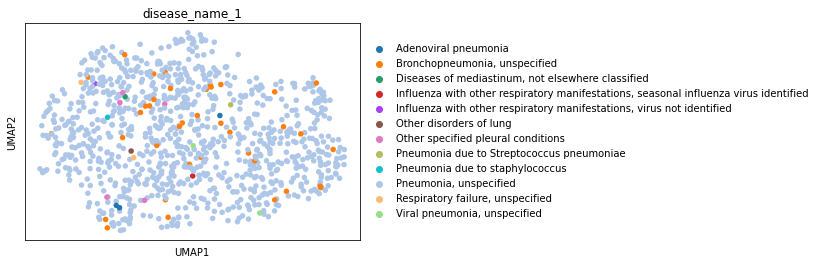

In [13]:
obs_only = list(pneumonia_influenza_df.columns[215:415])
obs_only.extend(["disease_type_1","disease_type_2","disease_name_1", 
                 "disease_name_2","INTIME", "OUTTIME", 
                 "SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", 
                 "FIRST_CAREUNIT", "LAST_CAREUNIT", "age_in_month"])

adata = ep.ad.df_to_anndata(pneumonia_influenza_df, columns_obs_only=obs_only)
ep.pp.knn_impute(adata, n_neighbours=20)
adata_enc = ep.pp.encode(adata, autodetect=True, encodings="one_hot_encoding")
adata_enc.layers["original_imputed"] = adata_enc.X.copy()
ep.pp.log_norm(adata_enc)
ep.pp.neighbors(adata_enc)
ep.tl.umap(adata_enc)
ep.pl.umap(adata_enc, color="disease_name_1",save="fig2_disease_name", legend_fontsize=8)

# Part C

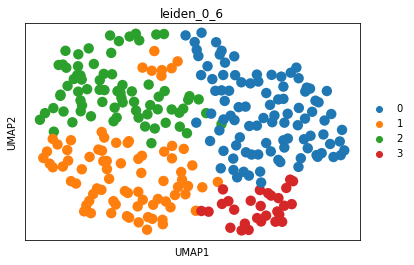

In [125]:
adata = ep.io.read_h5ad("../../anndata_objects/adata_02_2023_pneumonia_unspecified_rest.h5ad")
ep.tl.leiden(adata, resolution=0.6, key_added="leiden_0_6")
ep.pl.umap(adata, color=["leiden_0_6"])

In [126]:
n_per_cluster = adata.obs['leiden_0_6'].value_counts()

In [127]:
pneumonia_vars = ["Neutrophils_max", "Neutrophils_avg", "Absolute Lymphocyte Count_max", "Absolute Lymphocyte Count_min", "Absolute Lymphocyte Count_avg",
                 "LOS", "Monocytes_max","Monocytes_avg","ehrapycat_sputum_positive_bacteria_1.0", "ehrapycat_sputum_positive_fungi_1.0","ehrapycat_Death_1", "Procalcitonin_max", "C-Reactive Protein_max", ]
pneumonia_adata_subset = adata[:, pneumonia_vars]
ep.tl.rank_features_groups(pneumonia_adata_subset, groupby="leiden_0_6", layer="original_imputed")
pneumonia_adata_subset.obs["Death"] = pneumonia_adata_subset.obs["Death"].astype("category")

Trying to set attribute `._uns` of view, copying.


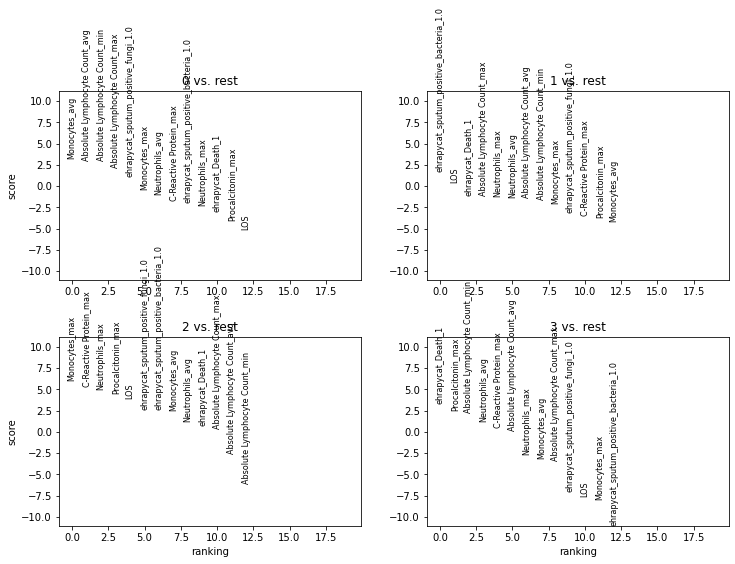

In [128]:
ep.pl.rank_features_groups(pneumonia_adata_subset,key="rank_features_groups", ncols=2)

In [129]:
liver_vars = ["Cholinesterase_min", "Gamma Glutamyltransferase_max", "Gamma Glutamyltransferase_avg",
               "Alanine Aminotransferase (ALT)_max", "Alanine Aminotransferase (ALT)_avg",
                "Prealbumin_min", "Prealbumin_max", "Albumin_min", "Albumin_max",
                "Asparate Aminotransferase (AST)_max", "Asparate Aminotransferase (AST)_avg", "Bilirubin, Total_max"]
liver_adata_subset = adata[:, liver_vars]
ep.tl.rank_features_groups(liver_adata_subset, groupby="leiden_0_6", layer="original_imputed")

Trying to set attribute `._uns` of view, copying.


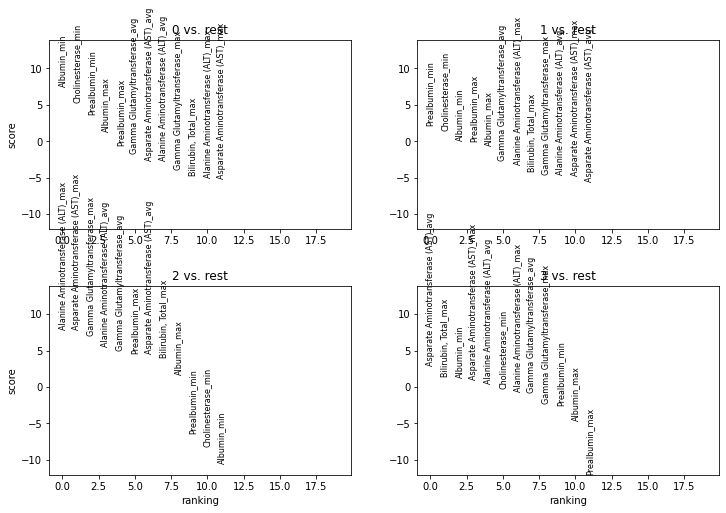

In [130]:
ep.pl.rank_features_groups(liver_adata_subset,key="rank_features_groups", ncols=2)

In [131]:
chlinical_chemie = ["Creatinine_max", "Platelet Count_min", "Lactate_max", "Calcium, Total_max", "Calcium, Total_min", "Potassium_max", "Potassium_min",
            "pH_min", "pH_max", "Sodium, Whole Blood_min", "Sodium, Whole Blood_max", "Chloride, Whole Blood_min", "Chloride, Whole Blood_max"]
cc_adata_subset = adata[:, chlinical_chemie]
ep.tl.rank_features_groups(cc_adata_subset, groupby="leiden_0_6", layer="original_imputed")

Trying to set attribute `._uns` of view, copying.


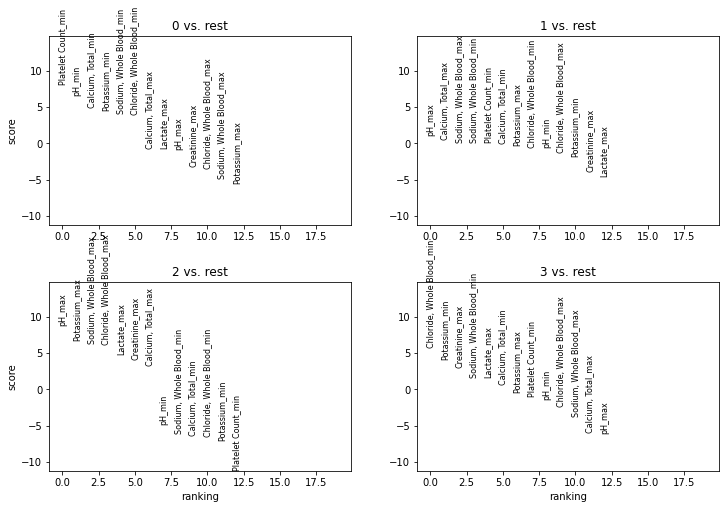

In [132]:
ep.pl.rank_features_groups(cc_adata_subset,key="rank_features_groups", ncols=2)

In [133]:
drugs_vars = [drug_column for drug_column in adata.var_names if "received" in drug_column and "1.0" in drug_column] # no duplicated encodes needed
drug_adata_subset = adata[:, drugs_vars]
ep.tl.rank_features_groups(drug_adata_subset, groupby="leiden_0_6", layer="original_imputed")

Trying to set attribute `._uns` of view, copying.


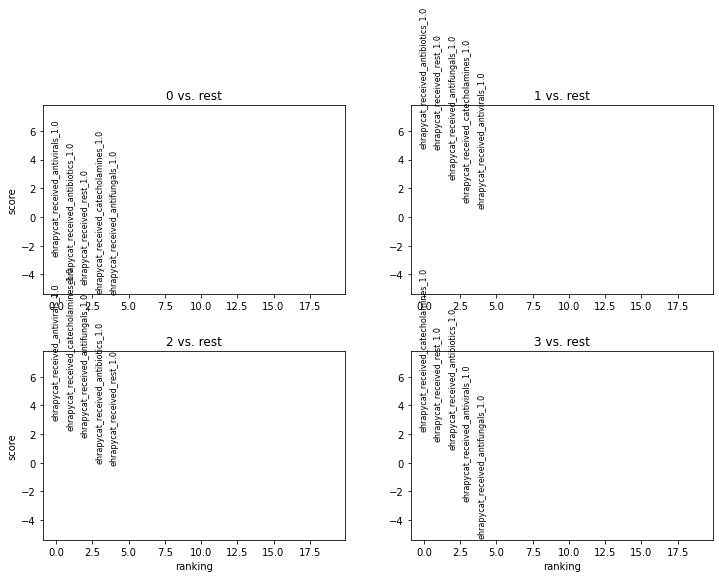

In [134]:
ep.pl.rank_features_groups(drug_adata_subset,key="rank_features_groups", ncols=2)

... storing 'Pneumonia unspecified - annotated' as categorical


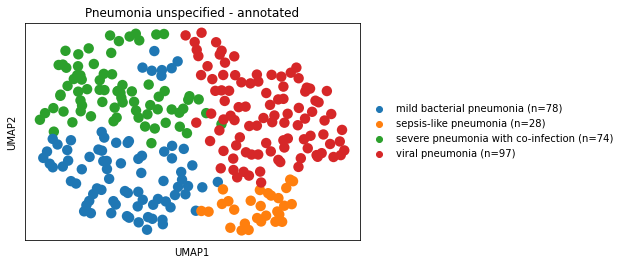

In [135]:
annotation = {
    "2": "severe pneumonia with co-infection (n=74)",
    "0": "viral pneumonia (n=97)",   
    "3": "sepsis-like pneumonia (n=28)",
    "1": "mild bacterial pneumonia (n=78)" 
}



pneumonia_adata_subset.obs["Pneumonia unspecified - annotated"] = [
    annotation[l] if l in annotation.keys() else l for l in adata.obs["leiden_0_6"]
]

ep.pl.umap(pneumonia_adata_subset, color="Pneumonia unspecified - annotated", save="fig3_anot_pneumonia.png")

In [136]:
ep.io.write("./adata_pneumonia_annotated.h5ad", adata)

In [137]:
pneumonia_adata_subset.uns["rank_genes_groups"] = pneumonia_adata_subset.uns.pop("rank_features_groups")
pneumonia_df_0 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="0")
pneumonia_df_1 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="1")
pneumonia_df_2 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="2")
pneumonia_df_3 = sc.get.rank_genes_groups_df(pneumonia_adata_subset, group="3")

In [138]:
drug_adata_subset.uns["rank_genes_groups"] = drug_adata_subset.uns.pop("rank_features_groups")
drug_df_0 = sc.get.rank_genes_groups_df(drug_adata_subset, group="0")
drug_df_1 = sc.get.rank_genes_groups_df(drug_adata_subset, group="1")
drug_df_2 = sc.get.rank_genes_groups_df(drug_adata_subset, group="2")
drug_df_3 = sc.get.rank_genes_groups_df(drug_adata_subset, group="3")

In [139]:
cc_adata_subset.uns["rank_genes_groups"] = cc_adata_subset.uns.pop("rank_features_groups")
cc_df_0 = sc.get.rank_genes_groups_df(cc_adata_subset, group="0")
cc_df_1 = sc.get.rank_genes_groups_df(cc_adata_subset, group="1")
cc_df_2 = sc.get.rank_genes_groups_df(cc_adata_subset, group="2")
cc_df_3 = sc.get.rank_genes_groups_df(cc_adata_subset, group="3")

In [140]:
liver_adata_subset.uns["rank_genes_groups"] = liver_adata_subset.uns.pop("rank_features_groups")
liver_df_0 = sc.get.rank_genes_groups_df(liver_adata_subset, group="0")
liver_df_1 = sc.get.rank_genes_groups_df(liver_adata_subset, group="1")
liver_df_2 = sc.get.rank_genes_groups_df(liver_adata_subset, group="2")
liver_df_3 = sc.get.rank_genes_groups_df(liver_adata_subset, group="3")

In [141]:
hm_features = ["ehrapycat_Death_1", "LOS", "ehrapycat_sputum_positive_bacteria_1.0","ehrapycat_sputum_positive_fungi_1.0",
               "Absolute Lymphocyte Count_max", "Neutrophils_max", 
               "Procalcitonin_max", "C-Reactive Protein_max", "Alanine Aminotransferase (ALT)_avg", 
               "Asparate Aminotransferase (AST)_max", "Gamma Glutamyltransferase_max", "Platelet Count_min"]

In [142]:
pneumonia_dfs = [pneumonia_df_0, pneumonia_df_1, pneumonia_df_2, pneumonia_df_3]
liver_dfs = [liver_df_0, liver_df_1, liver_df_2, liver_df_3]
cc_dfs = [cc_df_0, cc_df_1, cc_df_2, cc_df_3]

In [143]:
temp_ls = []
for pneu_feat in hm_features[:8]:
    for df in pneumonia_dfs:
        row = df.loc[df.names == pneu_feat].iloc[0].to_list()
        temp_ls.append(row)

for liver_feat in hm_features[8:11]:
    for df in liver_dfs:
        row = df.loc[df.names == liver_feat].iloc[0].to_list()
        temp_ls.append(row)

for cc_feat in hm_features[11:]:
    for df in cc_dfs:
        row = df.loc[df.names == cc_feat].iloc[0].to_list()
        temp_ls.append(row)

In [144]:
temp_df = pd.DataFrame(temp_ls, columns=["name", "score", "logfoldchange", "pval", "pval_adj"])
temp_df.drop(["logfoldchange", "pval", "pval_adj", "name"], axis=1, inplace=True)

In [145]:
result = pd.DataFrame(temp_df.values.reshape(-1,4)).T
result.columns = ["death","length of stay", "sputum_pos_bacteria", "sputum_pos_fungi", "lymphocytes", "neutrophils", "PCT", "CRP", "ALT", "AST", "GGT", "platelets count"]

updated_column_names = {
    'sputum_pos_bacteria': 'sputum bacteria',
    'sputum_pos_fungi': 'sputum fungi',
    'platelets count': 'platelets'
}
result.rename(columns=updated_column_names, inplace=True)

In [146]:
# we need to add age_in_month as well (its not added to var so its added independetly here)
# the score is not important it should just show an overview how the groups behave differently
from sklearn.preprocessing import MinMaxScaler
age_df = pneumonia_adata_subset.obs[["age_in_month", "Pneumonia unspecified - annotated"]]
avg_age = age_df.groupby('Pneumonia unspecified - annotated')['age_in_month'].mean().reset_index()
# Rename the columns for clarity (optional)
avg_age.columns = ['Pneumonia unspecified - annotated', 'avg age']
result["age in month"] = avg_age["avg age"]/10 # to get in line wit the scores of the other values
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(result), columns=result.columns)

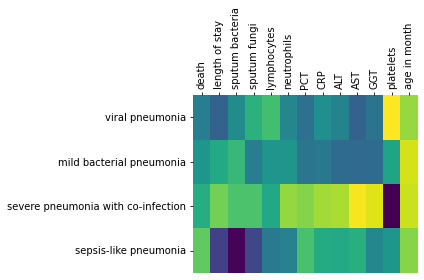

In [147]:
import matplotlib.pyplot as plt
ax = sns.heatmap(result, cmap="viridis", cbar=False)
ax.set(xlabel="", ylabel="")
ax.set_yticklabels(["viral pneumonia","mild bacterial pneumonia", "severe pneumonia with co-infection", "sepsis-like pneumonia"])
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=0)
ax.xaxis.tick_top()
plt.tight_layout()
plt.savefig("./fig_3_feature_heatmap.png") 

# Part D

In [148]:
preprocessed_df = pd.read_csv("../per_day.csv")
# should remove this earlier
preprocessed_df.drop(["language", "religion", "marital_status"], inplace=True, axis=1)
# focus on infants
preprocessed_df = preprocessed_df.loc[(preprocessed_df.age_in_month > 13) & (preprocessed_df.disease_name_1 == "Pneumonia, unspecified")]
# shift negative values for log_norm -> see #402 in ehrapy, do this after anndata creation!
for neg_col in ["Base Excess_min", "Base Excess_max", "Base Excess_avg", "Excrement_avg", "Excrement_min", "Excrement_max"]:
    abs_min = abs(preprocessed_df[neg_col].min())
    preprocessed_df[neg_col] = preprocessed_df[neg_col] + abs_min

In [149]:
cand_patient = preprocessed_df.loc[preprocessed_df.HADM_ID == 102315]
cand_patient = cand_patient.reset_index()
cand_patient = cand_patient.rename(columns={"index":"day"})
cand_patient['day'] = cand_patient.index

In [150]:
cortison_like = ['Beclomethasone dipropionate inhalation suspension', 'Dexamethasone Sodium Phosphate Injection',
                'Methylprednisolone Sodium Succinate for Injection','Dexamethasone Acetate Tablets', 'Prednisone Acetate Tablets']

anastehtics = ['Phenobarbital Sodium for Injection', 'Lidocaine Hydrochloride Injection','Ibuprofen Suspension',
              'Propofol Injectable Emulsion','Phenobarbital Tablets','Vecuronium Bromide for Injection', 'Indometacin Enteric-coated Tablets']

respiratory_drugs = ['Salbutamol Sulfate Nebules Inhalation Solution', 'Ambroxol Hydrochloride and Glucose Injection', 'Terbutaline Sulphate Solution for Nebulization']

cardiovascular_drugs = ['Urokinase for Injection','Captopril Tablets', 'Human Prothrombin Complex', 'Nifedipine Tablets',
                       'Digoxin Oral Solution', 'Nimodipine Injection', 'Spironolactone Tablets', 'Furosemide Injection']

electrolytes_solutions = ['10% Potassium Chloride Injection', 'Concentrated Sodium Chloride Injection', 
                         'Sterile Water Injection', '(4:1)Glucose and Sodium Chloride Injection', '10% Potassium Chloride Oral Solution',
                         '5% Glucose and Sodium Chloride Injection', ]

In [151]:
drugs = set(pd.unique(cand_patient.columns[15:215]))

ab_matches = ["amoxi", "cef", "clinda", "imi", "mero", "azit", "vanco", "tige", "linezol", "cillin", "mycin", "levoflo", "Sulfamethoxazole", "nitrofur"]
catecholamines_matches = ["epineph", "adrena", "isopren", "dobut", "dopamin"]
antiviral_matches = ["vir"] 
antifungal_matches = ["caspofu", "voricona", "flucona", "fungi"]
ab, cats, vir, fung, rest = [],[],[],[],[]

for drug_ in drugs:
    if any([drug in drug_.lower() for drug in ab_matches]):
        ab.append(drug_)
    elif any([drug in drug_.lower() for drug in catecholamines_matches]):
        cats.append(drug_)
    elif any([drug in drug_.lower() for drug in antiviral_matches]):
        vir.append(drug_)
    elif any([drug in drug_.lower() for drug in antifungal_matches]):
        fung.append(drug_)
    else:
        rest.append(drug_)

In [152]:
prescriptions_df = pd.read_csv("../../V1.1.0/PRESCRIPTIONS.csv")
prescriptions_df = prescriptions_df[["HADM_ID", "STARTDATE", "DRUG_NAME_EN", "DOSE_VAL_RX"]]
prescriptions_df = prescriptions_df.loc[prescriptions_df.HADM_ID == 102315]
prescriptions_df['STARTDATE'] = prescriptions_df['STARTDATE'].str.split(' ').str.get(0)

In [153]:
prescriptions_df['STARTDATE'] = pd.to_datetime(prescriptions_df['STARTDATE']) 
date_range = list(pd.date_range(start="2092-12-30", end="2093-01-13"))
date_dct = {}
for idx, date in enumerate(date_range):
    date_dct[str(date.date())] = idx
prescriptions_df['STARTDATE'] = prescriptions_df['STARTDATE'].astype(str)
prescriptions_df['days_since_admission'] = prescriptions_df['STARTDATE'].map(date_dct)

In [154]:
prescriptions_df["drug_class"] = prescriptions_df['DRUG_NAME_EN'].apply(lambda drug: "Antibiotic" if drug in ab else 'Antiviral' if drug in vir else 'Antifungal' if drug in fung else 'Catecholamines' if drug in cats else
                                                                        'Cortisol_like' if drug in cortison_like else 'Anaesthetic' if drug in anastehtics else 'Respiratory_drug' if drug in respiratory_drugs else 
                                                                        'Cardiovascular_drug' if drug in cardiovascular_drugs else 'Electrolytes' if drug in electrolytes_solutions else 'Rest')
prescriptions_df.drop(["HADM_ID", "STARTDATE", "DRUG_NAME_EN"], inplace=True, axis=1)

In [155]:
prescriptions_df_no_rest = prescriptions_df.loc[prescriptions_df["drug_class"] != "Rest"]

In [156]:
drug_classes_daily_dose = prescriptions_df_no_rest.groupby(["days_since_admission", "drug_class"]).agg({"DOSE_VAL_RX":"sum"})

In [157]:
drug_classes_daily_dose = drug_classes_daily_dose.unstack().fillna(0)
drug_classes_daily_dose.columns = drug_classes_daily_dose.columns.droplevel(0)
drug_classes_daily_dose = drug_classes_daily_dose.rename_axis(None, axis=1)

In [158]:
cand_frame = cand_patient[["day", "Neutrophils_max", "C-Reactive Protein_max", "Procalcitonin_max", "Alanine Aminotransferase (ALT)_max", "Monocytes_max"]]
cand_frame = cand_frame.assign(Antibiotic = drug_classes_daily_dose["Antibiotic"], Antiviral = drug_classes_daily_dose["Antiviral"], Catecholamines = drug_classes_daily_dose["Catecholamines"], Cortisol_like = drug_classes_daily_dose["Cortisol_like"], Cardiovascular = drug_classes_daily_dose["Cardiovascular_drug"], Electrolytes = drug_classes_daily_dose["Electrolytes"])

In [167]:
cand_frame = cand_frame.rename(columns={'Cortisol_like': 'Corticosteroids', 'Cardiovascular': 'Anticoagulants'})
cand_frame = cand_frame.rename(columns={'C-Reactive Protein_max': 'C-Reactive Protein (mg/dl)', "Monocytes_max": "Monocytes (10⁹/L)", 
                                        "Neutrophils_max": "Neutrophils (10⁹/L)", "Procalcitonin_max": "Procalcitonin (ng/ml)", 
                                        "Alanine Aminotransferase (ALT)_max": "Alanine Aminotransferase (ALT) (U/L)"})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


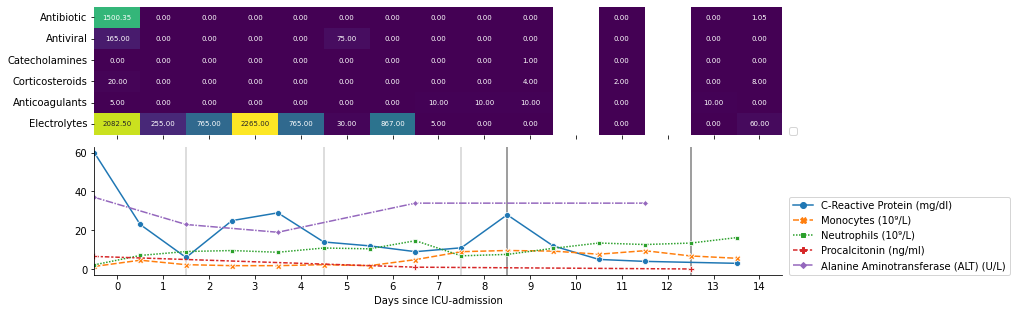

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize=(18, 5), sharex=True, layout='constrained')
ax[0].set_xlim(0,14)
ax[0].set_xticks(range(0,15))
plt.axvline(2, color='lightgrey') # cultures negative
plt.axvline(5, color='lightgrey') # cultures negative
plt.axvline(8, color='lightgrey') # cultures negative
plt.axvline(9, color='grey') # sputum culture Acinetobacter baumanii
plt.axvline(13, color='grey') # sputum culture G+ cocci
ax[1].set_xlabel("Days since ICU-admission")
g = sns.lineplot(data=cand_frame[["C-Reactive Protein (mg/dl)", "Monocytes (10⁹/L)", "Neutrophils (10⁹/L)", "Procalcitonin (ng/ml)", "Alanine Aminotransferase (ALT) (U/L)"]], markers=True)
g_2 = sns.heatmap(cand_frame[["Antibiotic", "Antiviral", "Catecholamines", "Corticosteroids", "Anticoagulants", "Electrolytes"]].T, annot=True, annot_kws={"fontsize": 7}, fmt='.2f', cmap="viridis", cbar=False, ax=ax[0])
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
ax[0].legend(loc=(1.01, 0))
ax[1].legend(loc=(1.01, 0))
plt.tight_layout()
#plt.show()
plt.savefig("./fig3_single_patient_lineplot_2.png")

In [177]:
s = pneumonia_adata_subset.obs.loc[adata.obs.HADM_ID == 102315]
s["Pneumonia unspecified - annotated"] # example patient is in the severe pneumonia with co-infection category

2349    severe pneumonia with co-infection (n=74)
Name: Pneumonia unspecified - annotated, dtype: category
Categories (4, object): ['mild bacterial pneumonia (n=78)', 'sepsis-like pneumonia (n=28)', 'severe pneumonia with co-infection (n=74)', 'viral pneumonia (n=97)']